<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/linear_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개요

이 문서에서는 `tf.estimator` API를 사용하여 로지스틱 회귀 모델(logistic regression model)을 훈련합니다. 이 모델은 다른 더 복잡한 알고리즘의 기초로 사용할 수 있습니다.


## 설정

In [1]:
!pip install sklearn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## 타이타닉 데이터셋을 불러오기
타이타닉 데이터셋을 사용할 것입니다. 성별, 나이, 클래스, 기타 등 주어진 정보를 활용하여 승객이 살아남을 것인지 예측하는 것을 목표로 합니다.

In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# 데이터셋 불러오기
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 데이터 탐험하기

데이터셋은 다음의 특성을 가집니다

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


훈련셋은 627개의 샘플로 평가셋은 264개의 샘플로 구성되어 있습니다.

In [8]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

대부분의 승객은 20대와 30대 입니다.

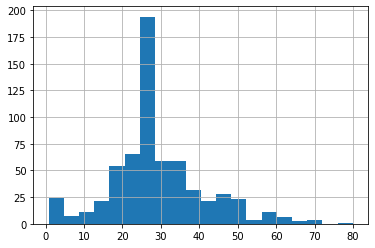

In [13]:
dftrain.age.hist(bins=20)

남자 승객이 여자 승객보다 대략 2배 많습니다.

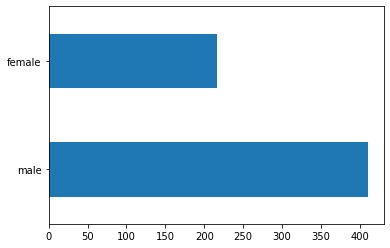

In [14]:
dftrain.sex.value_counts().plot(kind='barh')

대부분의 승객은 "삼등석" 입니다.

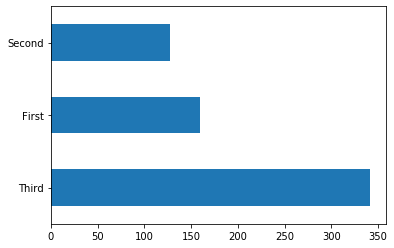

In [15]:
dftrain['class'].value_counts().plot(kind='barh')

여자는 남자보다 살아남을 확률이 훨씬 높습니다. 이는 명확하게 모델에 유용한 특성입니다.

Text(0.5, 0, '% survive')

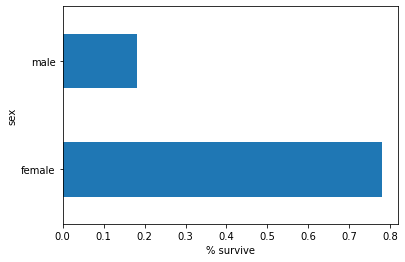

In [17]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## 모델을 위한 특성 공학(feature engineering)
추정기는 [특성 열(feature columns)](https://www.tensorflow.org/guide/feature_columns)이라는 시스템을 사용하여 모델이 각각의 입력 특성을 어떻게 해석할지 설명합니다. 추정기가 숫자 입력 벡터를 요구하면, *특성 열*은 모델이 어떻게 각 특성을 변환해야하는지 설명합니다.

효과적인 모델 학습에서는 적절한 특성 열을 고르고 다듬는 것이 키포인트 입니다. 하나의 특성 열은 특성 딕셔너리(dict)의 원본 입력으로 만들어진 열(*기본 특성 열*)이거나 하나 이상의 기본 열(*얻어진 특성 열*)에 정의된 변환을 이용하여 새로 생성된 열입니다.

선형 추정기는 수치형, 범주형 특성을 모두 사용할 수 있습니다. 특성 열은 모든 텐서플로 추정기와 함께 작동하고 목적은 모델링에 사용되는 특성들을 정의하는 것입니다. 또한 원-핫-인코딩(one-hot-encoding), 정규화(normalization), 버킷화(bucketization)와 같은 특성 공학 방법을 지원합니다.

### 기본 특성 열

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

`input_function`은 입력 파이프라인을 스트리밍으로 공급하는 `tf.data.Dataset`으로 데이터를 변환하는 방법을 명시합니다. `tf.data.Dataset`은 데이터 프레임, CSV 형식 파일 등과 같은 여러 소스를 사용합니다.

In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

다음과 같이 데이터셋을 점검할 수 있습니다:

In [23]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('특성 키:', list(feature_batch.keys()))
    print()
    print('클래스 배치:', feature_batch['class'].numpy())
    print()
    print('레이블 배치:', label_batch.numpy())

특성 키: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

클래스 배치: [b'Second' b'First' b'First' b'Second' b'Second' b'Second' b'First'
 b'Third' b'Third' b'Second']

레이블 배치: [1 0 0 0 0 0 1 0 0 0]


또한 `tf.keras.layers.DenseFeatures` 층을 사용하여 특정한 특성 열의 결과를 점검할 수 있습니다:

In [24]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[31.],
       [71.],
       [29.],
       [36.],
       [35.],
       [28.],
       [22.],
       [28.],
       [19.],
       [57.]], dtype=float32)

`DenseFeatures`는 조밀한(dense) 텐서만 허용합니다. 범주형 데이터를 점검하려면 우선 범주형 열에 indicator_column 함수를 적용해야 합니다:

In [25]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

모든 기본 특성을 모델에 추가한 다음에 모델을 훈련해 봅시다. 모델을 훈련하려면 `tf.estimator` API를 이용한 메서드 호출 한번이면 충분합니다:

In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.83008873, 'auc_precision_recall': 0.7991064, 'average_loss': 0.48032397, 'label/mean': 0.375, 'loss': 0.47353664, 'precision': 0.6666667, 'prediction/mean': 0.4012944, 'recall': 0.64646465, 'global_step': 200}


이제 정확도 75%에 도달했습니다. 별도로 각 기본 특성 열을 사용하면 데이터를 설명하기에는 충분치 않을 수 있습니다. 예를 들면, 성별과 레이블간의 상관관계는 성별에 따라 다를 수 있습니다. 따라서 `gender="Male"`과 'gender="Female"`의 단일 모델가중치만 배우면 모든 나이-성별 조합(이를테면 `gender="Male" 그리고 'age="30"` 그리고 `gender="Male"` 그리고 `age="40"`을 구별하는 것)을 포함시킬 수 없습니다.

서로 다른 특성 조합들 간의 차이를 학습하기 위해서 모델에 *교차 특성 열*을 추가할 수 있습니다(또한 교차 열 이전에 나이 열을 버킷화할 수 있습니다):

In [0]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

조합 특성을 모델에 추가하고 모델을 다시 훈련합니다:

In [29]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.8525559, 'auc_precision_recall': 0.7823517, 'average_loss': 0.46483946, 'label/mean': 0.375, 'loss': 0.45428944, 'precision': 0.7032967, 'prediction/mean': 0.34691024, 'recall': 0.64646465, 'global_step': 200}


이제 정확도 77.6%에 도달했습니다. 기본 특성만 이용한 학습보다는 약간 더 좋았습니다. 더 많은 특성과 변환을 사용해서 더 잘할 수 있다는 것을 보여주세요!

이제 훈련 모델을 이용해서 평가셋에서 승객에 대해 예측을 할 수 있습니다. 텐서플로 모델은 한번에 샘플의 배치 또는 일부에 대한 예측을 하도록 최적화되어있습니다. 앞서, `eval_input_fn`은 모든 평가셋을 사용하도록 정의되어 있었습니다.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpecxh5hev/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

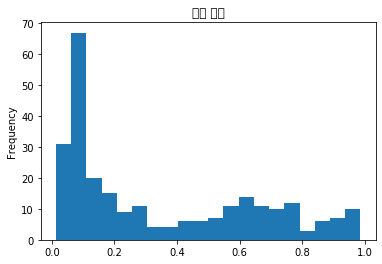

In [30]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='예측 확률')

마지막으로, 수신자 조작 특성(receiver operating characteristic, ROC)을 살펴보면 정탐률(true positive rate)과 오탐률(false positive rate)의 상충관계에 대해 더 잘 이해할 수 있습니다. 

(0, 1.05)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text

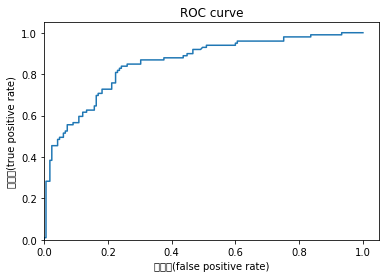

In [31]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('오탐률(false positive rate)')
plt.ylabel('정탐률(true positive rate)')
plt.xlim(0,)
plt.ylim(0,)